# User Manual
## 1. How to get the NFEM teaching tool
The NFEM teaching tool is hosted on gitlab.lrz.de. You can create an account using your TUM-id.
If you follow the link https://gitlab.lrz.de/chair_of_structural_analysis/NFEM_Teaching_Tool/tags, you will see a list of the releases of the NFEM tool. Please always download the latest version if nothing else is announced.

Download the .zip file and **unzip** it somewhere on your hard disk.

### 1.2 Get it using Git
If you are experienced with Git, you can also clone the repository.

## 2. Run a first example

The NFEM teaching tool is a python toolbox that can be imported in any python script. 
In the following, a simple example of a two-bar truss will be used to show the main functionalities.

### 2.1 Import the necessary python modules

In order to run the NFEM teaching tool from an arbitrary location, you first need to make the directory where you stored the NFEM teaching tool known to the system. 

You can use absolute or relative paths, e.g. ```'..'``` is the parent directory of the script.


In [32]:
# add the path to the nfem tool to the PATH.
import sys
sys.path.append('..') 

Now you can import everything from the NFEM teaching tool

In [33]:
from nfem import *

Often also other modules like e.g. 'numpy' are necessary, if you want to use those you should also import them here

In [34]:
import numpy as np

### 2.2 Preprocessing

As a first step you create the finite element model, using node, elements, loads, and boundary conditions. The id of nodes, elements, and loads can be an integer or a string.

In [35]:
# create the model
model = Model('Two-Bar Truss')

# add the nodes
model.add_node(id='A', x=0, y=0, z=0)
model.add_node(id='B', x=1, y=1, z=0)
model.add_node(id='C', x=2, y=0, z=0)

# add the truss elements
model.add_truss_element(id=1, node_a='A', node_b='B', youngs_modulus=1, area=1)
model.add_truss_element(id=2, node_a='B', node_b='C', youngs_modulus=1, area=1)

# add a single load
model.add_single_load(id='load 1', node_id='B', fv=-1)

# add the supports
model.add_dirichlet_condition(node_id='A', dof_types='uvw', value=0)
model.add_dirichlet_condition(node_id='B', dof_types='w', value=0)
model.add_dirichlet_condition(node_id='C', dof_types='uvw', value=0)

Now you can already have a look at the model you created. 

(Please ignore the ```%matplotlib inline```, it is only necessary here to show the plot directly in the manual)

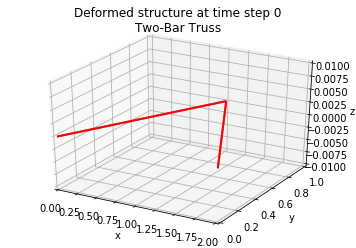

In [36]:
%matplotlib inline
#ignore the line above
show_deformation_plot(model)

### 2.3 Linear analysis

First create a new model for the first loading step

In [37]:
# create a new model for each solution step, using the initial model as a reference
linear_model = model.get_duplicate()

Set the load factor $\lambda$. Note that ```lambda``` is a python keyword, therefore we named the variable ```lam```

In [38]:
# define the load factor
linear_model.lam = 0.1

Perform a linear solution step

In [39]:
# perform a linear solution
linear_model.perform_linear_solution_step()

And now for a next solution step with a different load factor we repeat these steps

In [40]:
# create a new model for each solution step, using the last model as a reference
linear_model = linear_model.get_duplicate() 
# define the load factor
linear_model.lam = 0.2
# perform a linear solution
linear_model.perform_linear_solution_step()

### 2.4 Non-linear analysis

For a non-linear analysis, in principle the same steps are necessary, just with a little more input needed from the user.
First create a new model for the first non-linear solution step, using the initial model as a starting point.

In [41]:
# create a new model for each solution step, using the initial model as a reference
non_linear_model = model.get_duplicate()

Now some user input is required. There are several predictor and path following methods available in the NFEM teaching tool.
Here we choose the most simple ones, you will hear more details in the following lectures and tutorials.

In [42]:
# define the load factor
lam = 0.1

# create predictor and path following method
predictor_method = LoadIncrementPredictor()
path_following_method = LoadControl(lam)        

Using those methods you can run a non-linear solution step

In [43]:
# perform a non-linear solution step
non_linear_model.perform_non_linear_solution_step(predictor_method=predictor_method, path_following_method=path_following_method)

Start non linear solution step...
  Newthon-Raphson converged in step 6.
  Residual norm: 1.5265566588595902e-16.
Solution found after 6 iteration steps.


And now for a next solution step with a different load factor we repeat these steps

In [44]:
# create a new model for each solution step, using the last model as a reference
non_linear_model = non_linear_model.get_duplicate()

# define the load factor
lam = 0.2

# create predictor and path following method
predictor_method = LoadIncrementPredictor()
path_following_method = LoadControl(lam) 

# perform a non-linear solution step
non_linear_model.perform_non_linear_solution_step(predictor_method=predictor_method, path_following_method=path_following_method)

Start non linear solution step...
  Newthon-Raphson converged in step 14.
  Residual norm: 1.0419443086107094e-13.
Solution found after 14 iteration steps.


### 2.5 Postprocessing

After you have done your calculations, you can postprocess your results.

#### Load displacement diagram

In order to compare the load displacement curves of the the linear and nonlinear analysis, you can create a 2D plot and add the load-displacement-curves of the two models. Note that you need to specify the dof you want to plot against the load factor $\lambda$. (Please ignore the ```%matplotlib inline```, it is only necessary here to show the plot directly in the manual)

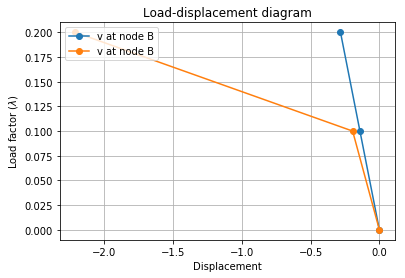

In [45]:
%matplotlib inline
#ignore the line above

# create a 2D plot 
plot = Plot2D()

# add the load-displacement curves you want to plot
plot.add_load_displacement_curve(linear_model, dof=('B', 'v'))
plot.add_load_displacement_curve(non_linear_model, dof=('B', 'v'))

# show the plot
plot.show()

#### Deformation plot

You can also visualize the deformation of the structure. As an example the linear_model is plotted.

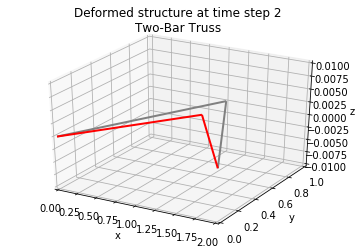

In [46]:
%matplotlib inline
#ignore the line above

# show a plot of the current deformation state
show_deformation_plot(linear_model)

#### Deformation animation

You can also animate the deformation history of each model, with the following command:
```python
# show an animation of the deformation history
show_history_animation(non_linear_model)
```